In [1]:
import re
import torch
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import math
import random
import torch.nn.functional as F

In [2]:
def read_bird_names(fname):
    names = []
    with open(fname, 'r') as fp:
        next(fp)
        for line in fp:
            if ",Aves," in line:
                toks = line.split(',')
                try:
                    name = toks[17].lower()
                    #remove any non a-z, apostrophe or space
                    name = re.sub(r'[^a-z\s]', '', name)
                    name = re.sub(r'\s+', '_', name)
                    name = name.strip()
                    if len(name) > 3:
                        names.append(name)
                except:
                    pass
    return sorted(list(set(names)))
words = read_bird_names("/Users/satyajitgupte/code/birds/taxa_english.csv")
random.shuffle(words)

In [3]:
words[:5]

['yukon_blackcapped_chickadee',
 'sonora_largebilled_sparrow',
 'empidonax_flycatchers',
 'pelzelns_todytyrant',
 'varied_tits_and_allies']

In [4]:
chars = sorted(list(set(''.join(words))))
# +1 for .
sz = len(chars) + 1
itos = {i+1:s for i,s in enumerate(chars)}
itos[0] = '.'
stoi = {s:i for i,s in itos.items()}

In [5]:
def make_dataset(words, block_size=2):
    xs = []
    ys = []
    for word in words:
        #print(word)
        context = [0]*block_size
        for char in word + '.':
            ix = stoi[char]
            ys.append(ix)
            xs.append(context)
            #print(f"{''.join(itos[c] for c in context)}->{itos[ix]}")
            context = context[1:] + [ix]
    return torch.tensor(xs), torch.tensor(ys)

In [6]:
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,Ytr = make_dataset(words[:n1], block_size=3)
Xdev,Ydev = make_dataset(words[n1:n2], block_size=3)
Xte,Yte = make_dataset(words[n2:], block_size=3)

In [7]:
Xtr.shape, Xdev.shape, Xte.shape

(torch.Size([451757, 3]), torch.Size([56547, 3]), torch.Size([56856, 3]))

In [34]:
def cmp(s, dt, t):
    ex_equals = torch.all(dt == t.grad).item()
    approx_equals = torch.allclose(dt, t.grad)
    max_diff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | ex:{str(ex_equals):5s} | approx:{str(approx_equals):5s} | maxdiff:{max_diff}')

In [8]:
n_embd = 10
block_size = 3
n_hidden = 64

C = torch.randn((sz, n_embd))
# Layer 1
W1 = torch.randn((block_size*n_embd), n_hidden) * 5/3 /(n_embd*block_size)**0.5
b1 = torch.randn(n_hidden) * 0.1

# Layer 2
W2 = torch.randn((n_hidden, sz)) * 0.1
b2 = torch.randn(sz) * 0.1

# BatchNorm params
bngain = torch.ones((1, n_hidden)) * 0.1 + 1
bnbias = torch.zeros((1, n_hidden)) * 0.1

# karapthy inits params (multiply by 0.1) because initing with 0 can hide errors in manual backprop

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for param in parameters:
    param.requires_grad = True
print("Parameters = ", sum(p.nelement() for p in parameters))

Parameters =  4212


In [9]:
batch_size = 32
n = batch_size
ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
Xb, Yb = Xtr[ix], Ytr[ix]

In [10]:
# forward pass - chunkated
emb = C[Xb]
embcat = emb.view(emb.shape[0], -1) # concat the embs
#Layer 1
hprebn = embcat @ W1 + b1
# Batch Norm
bnmeani = (1/n)*hprebn.sum(dim=0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = (1/(n-1))*bndiff2.sum(dim=0, keepdim=True)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff*bnvar_inv
hpreact = bngain * bnraw + bnbias

# Non Linearity
h = torch.tanh(hpreact)

# Linear Layer 2
logits = h @ W2 + b2

# softmax 
logits_max = logits.max(1, keepdim=True).values
norm_logits = logits - logits_max # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum**-1
probs = counts*counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# pytorch backward pass
for param in parameters:
    param.grad = None
    
for t in [logprobs, probs, counts_sum_inv, counts_sum, counts, norm_logits, logits_max, logits,
         h, hpreact, bnraw, bnvar_inv, bnvar, bndiff2, bndiff, bnmeani, hprebn, embcat, emb]:
    t.retain_grad()
    
loss.backward()







In [133]:
emb.shape, C.shape, Xb.shape

(torch.Size([32, 3, 10]), torch.Size([28, 10]), torch.Size([32, 3]))

In [139]:
# manual backprop
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
dprobs = (1/probs) * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = (-1 * (counts_sum)**-2) * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = norm_logits.exp() * dcounts # norm_logits.exp() is just counts, so we can also write as counts * dcounts
dlogits = dnorm_logits.clone()
dlogits_max = -(dnorm_logits).sum(1, keepdim=True)
dlogits += F.one_hot(logits.max(1).indices, dlogits.shape[1]) * dlogits_max
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = (bngain * dhpreact)
dbnbias = dhpreact.sum(0, keepdim=True)
dbndiff = bnvar_inv * dbnraw 
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5)*((bnvar+1e-5)**-1.5) * dbnvar_inv
dbndiff2 = (1/(n-1)) * torch.ones_like(bndiff2) * dbnvar
dbndiff += 2*(bndiff)*dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = -(dbndiff).sum(0, keepdim=True)
dhprebn += (1/n)*(torch.ones_like(hprebn)*dbnmeani)
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
dembcat = dhprebn @ W1.T
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k][j]
        dC[ix] += demb[k][j]

cmp('dlogprobs', dlogprobs, logprobs)
cmp('dprobs', dprobs, probs)
cmp('dcounts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('dcounts_sum', dcounts_sum, counts_sum)
cmp('dcounts', dcounts, counts)
cmp('dnorm_logits', dnorm_logits, norm_logits)
cmp('dlogits_max', dlogits_max, logits_max)
cmp('dlogits', dlogits, logits)
cmp('dh', dh, h)
cmp('dW2', dW2, W2)
cmp('db2', db2, b2)
cmp('dhpreact', dhpreact, hpreact)
cmp('dbngain', dbngain, bngain)
cmp('dbnraw', dbnraw, bnraw)
cmp('dbnbias', dbnbias, bnbias)

cmp('dbnvar_inv', dbnvar_inv, bnvar_inv)
cmp('dbnvar', dbnvar, bnvar)
cmp('dbndiff2', dbndiff2, bndiff2)
cmp('dbndiff', dbndiff, bndiff)
cmp('dhprebn', dhprebn, hprebn)
cmp('dbnmeani', dbnmeani, bnmeani )
cmp('dW1', dW1, W1)
cmp('db1', db1, b1)
cmp('dembcat', dembcat, embcat)
cmp('dC', dC, C)

dlogprobs       | ex:True  | approx:True  | maxdiff:0.0
dprobs          | ex:True  | approx:True  | maxdiff:0.0
dcounts_sum_inv | ex:True  | approx:True  | maxdiff:0.0
dcounts_sum     | ex:True  | approx:True  | maxdiff:0.0
dcounts         | ex:True  | approx:True  | maxdiff:0.0
dnorm_logits    | ex:True  | approx:True  | maxdiff:0.0
dlogits_max     | ex:True  | approx:True  | maxdiff:0.0
dlogits         | ex:True  | approx:True  | maxdiff:0.0
dh              | ex:True  | approx:True  | maxdiff:0.0
dW2             | ex:True  | approx:True  | maxdiff:0.0
db2             | ex:True  | approx:True  | maxdiff:0.0
dhpreact        | ex:True  | approx:True  | maxdiff:0.0
dbngain         | ex:True  | approx:True  | maxdiff:0.0
dbnraw          | ex:True  | approx:True  | maxdiff:0.0
dbnbias         | ex:True  | approx:True  | maxdiff:0.0
dbnvar_inv      | ex:True  | approx:True  | maxdiff:0.0
dbnvar          | ex:True  | approx:True  | maxdiff:0.0
dbndiff2        | ex:True  | approx:True  | maxd

In [143]:
## exercise 2 - backprop through cross entropy all in one go - directly into dlogits 
loss_fast = F.cross_entropy(logits, Yb)
loss_fast.item()

3.5067431926727295

In [145]:
dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits/=n

cmp('dlogits', dlogits, logits)

dlogits         | ex:False | approx:True  | maxdiff:4.6566128730773926e-09


In [146]:
dlogits.shape

torch.Size([32, 28])

In [151]:
dlogits[0].sum(0)

tensor(-2.3283e-09, grad_fn=<SumBackward1>)

In [152]:
Yb

tensor([ 2,  6,  2,  6,  2,  5,  6,  1, 22, 16,  1, 16, 15,  5,  1, 24, 20,  2,
         9, 19,  9, 19,  4, 15,  2,  8,  5, 10, 17, 15, 13,  6])

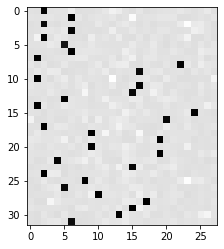

In [158]:
plt.figure(figsize=(4,4))
plt.imshow(dlogits.detach(), cmap='gray')

In [162]:
# exercise 3 - batch norm in one go 
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True))/(torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True)) + 1e-5) + bnbias

In [166]:
print("max diff", (hpreact - hpreact_fast).abs().max().item())

max diff 1.9073486328125e-05


In [164]:
hpreact

tensor([[-0.4598,  1.2692, -1.5245,  ...,  0.9709, -0.8569,  0.0478],
        [ 0.8229, -0.8626,  0.3934,  ..., -0.9928,  0.9970,  1.5302],
        [ 0.6999, -0.0329,  0.4582,  ...,  0.9343,  2.0105,  0.6890],
        ...,
        [ 0.4156, -0.5754,  1.3126,  ...,  1.1792, -0.4452, -1.1641],
        [ 0.0340,  0.2886,  2.2573,  ...,  0.2320,  0.6122, -1.6238],
        [ 0.2789,  0.2242, -1.6070,  ...,  0.9060, -0.7442,  2.0736]],
       grad_fn=<AddBackward0>)

In [167]:
# backprop through batchnorm 

# before we had
# dbnraw = (bngain * dhpreact)
# dbnbias = dhpreact.sum(0, keepdim=True)
# dbndiff = bnvar_inv * dbnraw 
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5)*((bnvar+1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1/(n-1)) * torch.ones_like(bndiff2) * dbnvar
# dbndiff += 2*(bndiff)*dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = -(dbndiff).sum(0, keepdim=True)
# dhprebn += (1/n)*(torch.ones_like(hprebn)*dbnmeani)

dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

In [168]:
cmp('dhprebn', dhprebn, hprebn)

dhprebn         | ex:False | approx:True  | maxdiff:9.313225746154785e-10


In [220]:
# Exercise 4 - Full optmization with manual backprop

n_embd = 10
block_size = 3
n_hidden = 64

C = torch.randn((sz, n_embd))
# Layer 1
W1 = torch.randn((block_size*n_embd), n_hidden) * 5/3 /(n_embd*block_size)**0.5
b1 = torch.randn(n_hidden) * 0.1

# Layer 2
W2 = torch.randn((n_hidden, sz)) * 0.1
b2 = torch.randn(sz) * 0.1

# BatchNorm params
bngain = torch.ones((1, n_hidden)) * 0.1 + 1
bnbias = torch.zeros((1, n_hidden)) * 0.1

# karapthy inits params (multiply by 0.1) because initing with 0 can hide errors in manual backprop

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for param in parameters:
    param.requires_grad = True
print("Parameters = ", sum(p.nelement() for p in parameters))


batch_size = 32
n = batch_size
max_steps = 200000
lossi = []

# since we are doing manual bacprop, dont need torch auutograd
with torch.no_grad():

    for i in range(max_steps):

        # get batch 
        ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
        Xb, Yb = Xtr[ix], Ytr[ix]

        # forward pass
        emb = C[Xb]
        embcat = emb.view(emb.shape[0], -1) # concat the embs

        # Layer 1
        hprebn = embcat @ W1 + b1

        # Batch Norm  
        bnmean = hprebn.mean(0, keepdim=True)
        bnvar = hprebn.var(0, keepdim=True, unbiased=True)
        bnvar_inv = (bnvar + 1e-5)**-0.5
        bnraw = (hprebn - bnmean) * bnvar_inv
        hpreact = bngain * bnraw+ bnbias

        # Non Linearity
        h = torch.tanh(hpreact)
        # Linear Layer 2
        logits = h @ W2 + b2   
        # cross entropy
        loss = F.cross_entropy(logits, Yb)


        # backprop
        for param in parameters:
            param.grad = None

        
        #loss.backward()



        # manual backprop
        dlogits = F.softmax(logits, 1)
        dlogits[range(n), Yb] -= 1
        dlogits/=n

        # 2nd layer backprop
        dh = dlogits @ W2.T
        dW2 = h.T @ dlogits
        db2 = dlogits.sum(0)
        # backprop through tanh
        dhpreact = (1.0 - h**2) * dh

        #batchnorm backprop
        dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
        dbnbias = dhpreact.sum(0, keepdim=True)

        # I just copied this from karpathy's notebook. 
        dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

        # 1st Layer 
        dembcat = dhprebn @ W1.T
        dW1 = embcat.T @ dhprebn
        db1 = dhprebn.sum(0)


        # backprop through embs 

        demb = dembcat.view(emb.shape)
        dC = torch.zeros_like(C)
        for k in range(Xb.shape[0]):
            for j in range(Xb.shape[1]):
                ix = Xb[k][j]
                dC[ix] += demb[k][j]

        grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
        # update grads
        lr = 0.1 if i < 100000 else 0.01
        for p, grad in zip(parameters, grads):
            #cmp("shape:{}".format(grad.shape), grad, p)

            #p.data += -lr*p.grad
            #print(p.shape, grad.shape)
            p.data += -lr*grad

        if i % 10000 == 0:
            print("Iter :{}/{} Loss:{:.4f}".format(i, max_steps, loss.item()))
        lossi.append(loss.item())
        #break








Parameters =  4212
Iter :0/200000 Loss:3.6234
Iter :10000/200000 Loss:2.3891
Iter :20000/200000 Loss:1.9550
Iter :30000/200000 Loss:2.3792
Iter :40000/200000 Loss:1.6772
Iter :50000/200000 Loss:2.6051
Iter :60000/200000 Loss:2.1344
Iter :70000/200000 Loss:2.2110
Iter :80000/200000 Loss:2.2993
Iter :90000/200000 Loss:1.5010
Iter :100000/200000 Loss:1.4020
Iter :110000/200000 Loss:2.0208
Iter :120000/200000 Loss:1.9258
Iter :130000/200000 Loss:1.8495
Iter :140000/200000 Loss:1.7163
Iter :150000/200000 Loss:1.8357
Iter :160000/200000 Loss:2.0494
Iter :170000/200000 Loss:2.1857
Iter :180000/200000 Loss:1.9870
Iter :190000/200000 Loss:1.8050


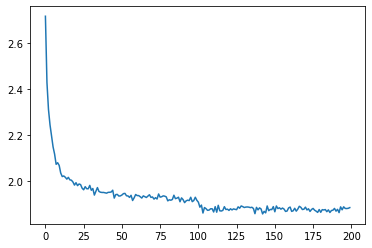

In [241]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(dim=1))

In [204]:
torch.tensor(lossi).view(-1, 2).mean(dim=1)

tensor([3.4125, 3.5151, 3.4015,  ..., 1.5967, 1.9766, 2.0802])

In [222]:
# calibrate batch norm at the end of training
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [223]:
@torch.no_grad
def evaluate_loss(split):
    X, Y = {
        "train": (Xtr, Ytr),
        "dev": (Xdev, Ydev),
        "test": (Xte, Yte)
    }[split]
    emb = C[X]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean)* (bnvar+1e-5)**-0.5 + bnbias
    
    # non-linearity
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(split, "Loss=", loss.item())
    

In [224]:
evaluate_loss("train")
evaluate_loss("dev")
evaluate_loss("test")

train Loss= 1.7864493131637573
dev Loss= 1.7827987670898438
test Loss= 1.8062044382095337


In [238]:
# sample from the model


for _ in range(20):
    context = [0] * block_size
    outs = []
    while True:
        emb = C[torch.tensor([context])]
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ W1 + b1
        hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, 1).item()
        context = context[1:] + [ix]
        outs.append(ix)
        if ix == 0:
            break
    print("".join(itos[i] for i in outs))

        
        

pler.
woodpecker.
earther.
narnch.
starbler.
nuzbao.
greer_tnaceeds_cry_burgemche_czudlightikz_oinchested_milpe_pen.
pal.
eantsas.
maleenneds_suluckownd_stowe_buy.
rufpes_anin.
chathroatellowe_petelrssnyshrikeet.
alarthel.
whiteeyeatches.
rctler.
mouddatgew_whiteeye.
eabird.
pinetailes_cis_ifinch.
pinian_boubler.
oop.
